<div style="text-align: right;">
<a target="_blank" href="https://colab.research.google.com/github/hkaragah/hkaragah.github.io/blob/main/earthquake/response_spectrum/response_spectrum.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<div style="font-size: 0.8em; color: #555;">By Hossein Karagah</div>
<div style="font-size: 0.8em; color: #555;">© Copyright 2025 GNU GENERAL PUBLIC LICENSE.</div>
</div>

# Earthquake Response Spectrum

The earthquake response spectrum is a plot that shows the maximum response of a series of single-degree-of-freedom (SDOF) oscillators to a specific ground motion (earthquake acceleration record), as a function of the oscillator's natural period or frequency.

The response spectrum can be plotted for:
- Displacement spectrum: max. relative displacement ($u_{max}$) vs. oscillator's period
- Velocity spectrum: max. relative velocity ($\dot{u}_{max}$) vs. oscillator's period
- Acceleration spectrum: max. relative acceleration ($\ddot{u}_{max}$) vs. oscillator's period
- Pseudo-velocity spectrum: approxiamte max. velocity response ($\omega_n u_{max}$) vs. oscillator's period
- Pseudo-acceleration spectrum: aproximate max. acceleration respopnse ($\omega_n^2u_{max}$) vs. oscillator's period

Before dive into calculating the reponse spectrum, let's obtain an earthquke record. I use <a url="https://ngawest2.berkeley.edu/">PEER Ground Motion Database</a> and download an earthquake record including acceleration, velocity, and displacement time histories.

---

## Import Earthquake Record

The records I selected to work on here are named

- `RSN5970_SIERRA.MEX_BOR360.AT2`, 
- `RSN5970_SIERRA.MEX_BOR360.VT2`, 
- `RSN5970_SIERRA.MEX_BOR360.DT2`

representing acceleration, velocity, and displacement time histories of __2010 Baja California earthquake__, respectively. The earthquake had a moment magnitude of 7.2 $M_w$ and maximum Mercalli intensity of VII. The epicenter was located in south of Guadalupe Vistoria, Baja California, Mexico (32.286°N  115.295°W) at a depth of 10 km (6.2 mile).

<img src="../../assets/img/earthquake/response_spectrum/response_spectrum_02.png" alt="2010 Baja California earthquake">

Let's examine the first 10 lines of `RSN5970_SIERRA.MEX_BOR360.AT2` file.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import os
import sys
sys.path.append(os.path.abspath("../.."))
import assets.modules.earthquake as eq


In [43]:
file_path = "../../assets/data/earthquak/peer_records_raw/"

name_str = "RSN5970_SIERRA.MEX_BOR360"

file_names = {
    "Acceleration": name_str + ".AT2", 
    "Velocity": name_str + ".VT2", 
    "Displacement": name_str + ".DT2"
}

file_name = os.path.join(file_path, file_names["Acceleration"])
with open(file_name, 'r') as file:
    lines = file.readlines()

# Print the first 10 lines of the file
for i in range(10):
    print(lines[i].strip())
print("...")
    

PEER NGA STRONG MOTION DATABASE RECORD
El Mayor-Cucapah, 4/4/2010, Borrego Springs, 360
ACCELERATION TIME SERIES IN UNITS OF G
NPTS=  30296, DT=   .0100 SEC
-.3595791E-05  -.3602476E-05  -.3609122E-05  -.3614762E-05  -.3622277E-05
-.3629087E-05  -.3634954E-05  -.3641761E-05  -.3647513E-05  -.3656279E-05
-.3661616E-05  -.3667165E-05  -.3672715E-05  -.3675396E-05  -.3683046E-05
-.3685863E-05  -.3696702E-05  -.3703039E-05  -.3704650E-05  -.3707040E-05
-.3713379E-05  -.3714652E-05  -.3718122E-05  -.3746092E-05  -.3728889E-05
-.3744301E-05  -.3756375E-05  -.3747034E-05  -.3767861E-05  -.3751488E-05
...


---

The data starts from line 5, and there is one recording every 0.01 seconds as explained in the headline. Also, the acceleration data is recorded in $g$, and there are five acceleration values per line. Performing similar examination on the files with `.VT2` and `.DT2` shows that the velocity and displacement values are measured in cm/s, and cm, respectively. 

Using this information, I will parse the files as follows.

In [44]:
DT = float(lines[3].split()[-2])  # Sampling time interval in seconds
FIRST_LINE = 5  # First line to read in the file
g = 9.81 * 100 # gravitational acceleration (cm/s2)

time, ground, header = {}, {}, {}
for key, name in file_names.items():
    path = os.path.join(file_path, name)
    time[key], ground[key], header[key] = eq.read_values(path, DT, FIRST_LINE)

# Print the first 5 values of the time and ground values
print("First 10 values of time and ground values:\n")
print("Time (s)    Acceleration (g)    Velocity (cm/s)    Displacement (cm)")
for i in range(10):
    print(f"{time['Acceleration'][i]:8}    {ground['Acceleration'][i]:16}    "
          f"{ground['Velocity'][i]:15}    {ground['Displacement'][i]:15}")


First 10 values of time and ground values:

Time (s)    Acceleration (g)    Velocity (cm/s)    Displacement (cm)
     0.0       -3.595791e-06                0.0                0.0
    0.01       -3.602476e-06       -3.52895e-05      -1.764475e-07
    0.02       -3.609122e-06      -7.064436e-05      -7.061168e-07
    0.03       -3.614762e-06      -0.0001060594      -1.589636e-06
    0.04       -3.622277e-06       -0.000141539      -2.827628e-06
    0.05       -3.629087e-06      -0.0001770888      -4.420768e-06
    0.06       -3.634954e-06      -0.0002127008      -6.369716e-06
    0.07       -3.641761e-06      -0.0002483749      -8.675094e-06
    0.08       -3.647513e-06      -0.0002841106      -1.133752e-05
    0.09       -3.656279e-06      -0.0003199174      -1.435766e-05


---

Let's plot the recording for this earthquake.

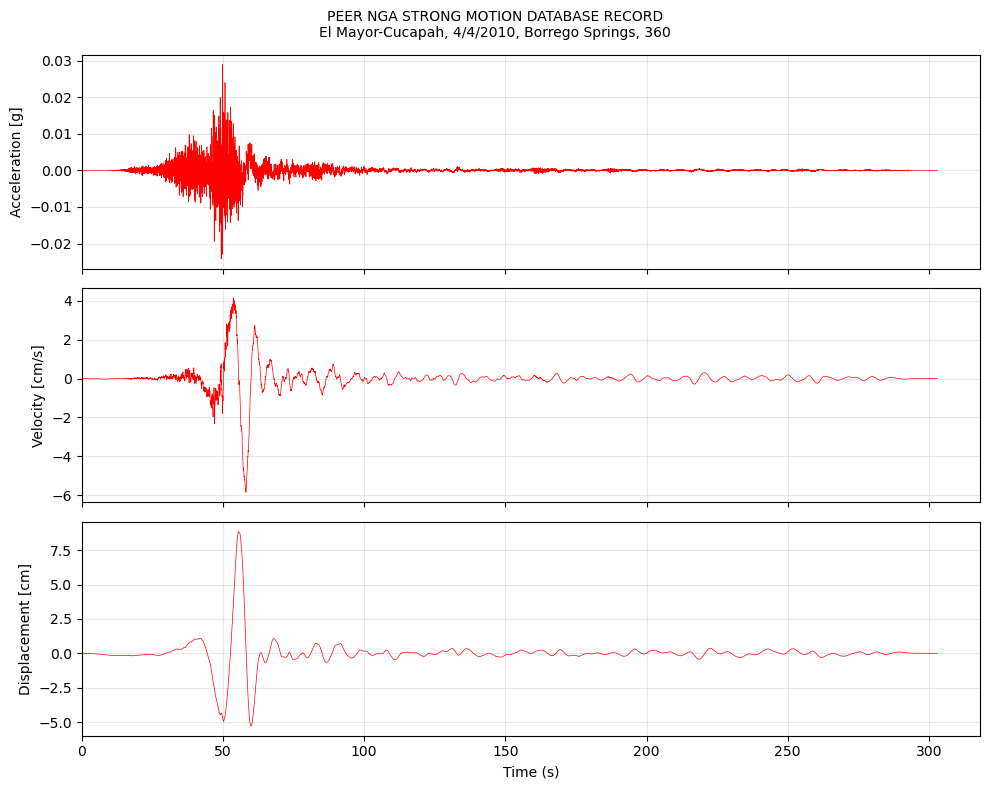

In [45]:
# Plot the earthquake records
plt.style.use('default')  # Use default style instead of seaborn
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

for i, key in enumerate(ground.keys()):
    ax[i].plot(time[key], ground[key], 'r-', label=key, linewidth=0.5)
    ax[i].set_ylabel(f'{key} [{header[key][-2].split()[-1].lower()}]')
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(left=0)

ax[-1].set_xlabel('Time (s)')
title_lines = list(header.values())[0]
plt.suptitle(f"{title_lines[0]}\n{title_lines[1]}", fontsize=10)
plt.tight_layout()
plt.show()

---

Usually recording devices records the ground acceleration, and the velocity and displacement are computed. To perform a quick check on the downloaded data, I will compute the velocity and displacement by integrating the acceleration using the trapizoid rule. Comparing the plots shows that computed velocity and displacement time histories closely follows the downloaded records.

In [46]:
# Compute the velocity and displacement from acceleration
acc = ground['Acceleration'] * g # ground acceleration in cm/s^2
vel, disp = eq.integrate_acceleration(acc, DT, 1, baseline_correction=False, highpass_filter=False)


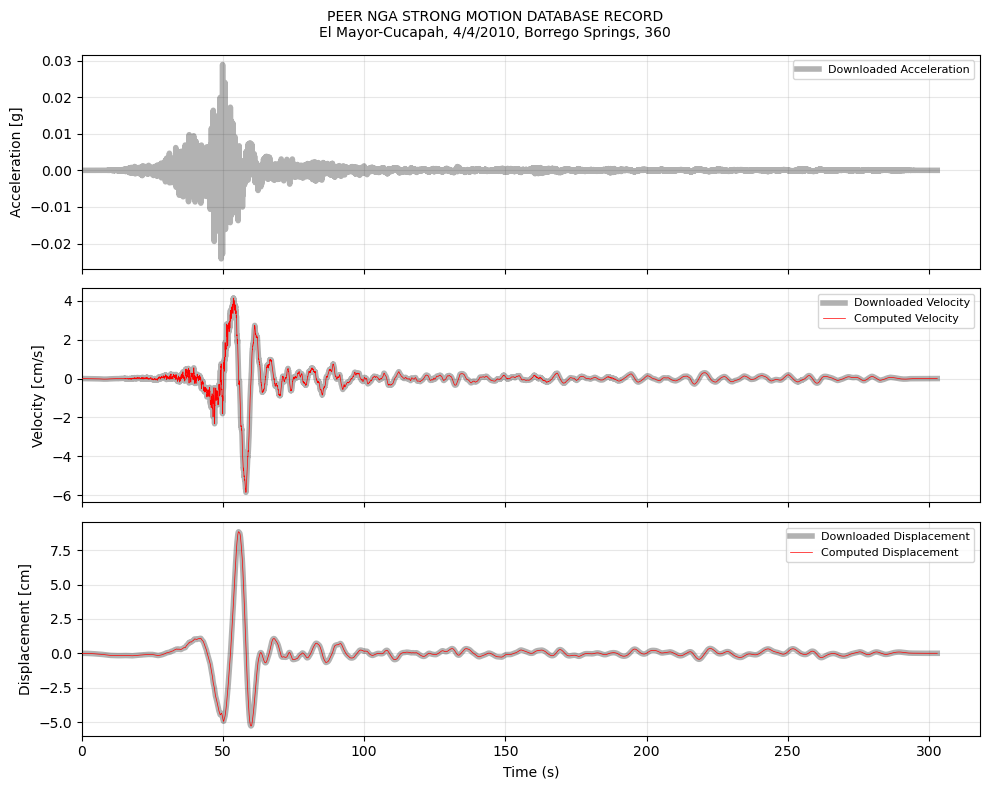

In [47]:
# Plot the earthquake records
plt.style.use('default')  # Use default style instead of seaborn
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

for i, key in enumerate(ground.keys()):
    ax[i].plot(time[key], ground[key], 'k-', alpha=0.3, label=f"Downloaded {key}", linewidth=4)
    if key == 'Velocity':
        ax[i].plot(time['Acceleration'], vel, 'r-', label='Computed Velocity', linewidth=0.5, zorder=10)
    elif key == 'Displacement':
        ax[i].plot(time['Acceleration'], disp, 'r-', label='Computed Displacement', linewidth=0.5, zorder=10)
    ax[i].set_ylabel(f'{key} [{header[key][-2].split()[-1].lower()}]')
    ax[i].grid(True, alpha=0.3)
    ax[i].set_xlim(left=0)
    ax[i].legend(loc='upper right', fontsize=8)

ax[-1].set_xlabel('Time (s)')
title_lines = list(header.values())[0]
plt.suptitle(f"{title_lines[0]}\n{title_lines[1]}", fontsize=10)
plt.tight_layout()
plt.show()


## SDOF Influenced by Ground Motion: Equation of Motion


<img src="../../assets/img/earthquake/response_spectrum/response_spectrum_01.jpg" alt="SDOF under groud motion" width=600>

The equation of motion for a Single Degree of Freedom (SDOF) system subjected to ground motion acceleration $\ddot{u}_g(t)$ is:

$$m\ddot{u}(t) + c\dot{u}(t) + ku(t) = -m\ddot{u}_g(t)$$

where:
* $m$, $k$, and $c$ are the mass, stiffness, and damping coefficient of the system, respectively
* $u(t)$, $\dot{u}(t)$, and $\ddot{u}(t)$ are the relative displacement,velocity, and acceleration of the mass with respect to the ground, respectively
* $\ddot{u}_g(t)$ is the ground acceleration

The equation of motion can be re-arranged as follows:

$$\ddot{u}(t) + \tfrac{c}{m}\dot{u}(t) + \tfrac{k}{m}u(t) = -\ddot{u}_g(t)$$

$$\ddot{u}(t) + 2\zeta\omega_n\dot{u}(t) + \omega_n^2u(t) = -\ddot{u}_g(t)$$

## Dynamic Properties

The system is characterized by its:

1. Natural frequency: $\omega_n = \sqrt{\frac{k}{m}}$
2. Natural period: $T_n = \frac{2\pi}{\omega_n}$
3. Damping ratio: $\zeta = \frac{c}{2m\omega_n}$

---

## Solution Methods

The solution can be obtained through several methods:

### 1. Time Domain Solution (Duhamel's Integral)

For zero initial conditions, the relative displacement response is given by:

$$u(t) = \frac{1}{m\omega_d}\int_0^t F(\tau)e^{-\zeta\omega_n(t-\tau)}\sin[\omega_d(t-\tau)]d\tau$$

where $\omega_d = \omega_n\sqrt{1-\zeta^2}$ is the damped natural frequency and $F(\tau)$ is the external force. Assuming that the external force is $F(\tau)=-m\ddot{u}_g(\tau)$, the above equation is transformed to 

$$u(t) = -\frac{1}{m\omega_d}\int_0^t -m\ddot{u}_g(\tau)e^{-\zeta\omega_n(t-\tau)}\sin[\omega_d(t-\tau)]d\tau$$

Simplifying this equation will lead to

$$u(t) = \frac{1}{\omega_d}\int_0^t \ddot{u}_g(\tau)e^{-\zeta\omega_n(t-\tau)}\sin[\omega_d(t-\tau)]d\tau$$


:::{note}

The Duhamel Integral is obtained by superposition of the responses of individual palses. So it can only be utilized to solve the equation of motion of linear systems. 

:::


### 2. Numerical Time Integration

Common numerical methods include:
* Newmark-β method
* Central Difference method
* Wilson-θ method

### 3. Frequency Domain Solution

The frequency response function (FRF) relates the input ground motion to the output displacement:

$$H(\omega) = \frac{\omega_n^2}{(\omega_n^2 - \omega^2) + 2i\zeta\omega_n\omega}$$

---

## Response Spectra

The response spectrum presents the maximum response of SDOF systems with different natural periods to a specific ground motion:

1. Displacement Response Spectrum ($S_d = \tfrac{1}{\omega_n}S_{pv}$)
2. Pseudo-Velocity Response Spectrum ($S_{pv}$)
3. Pseudo-Acceleration Response Spectrum ($Sp_a = \omega_n S_{pv}$)

These spectra are essential tools in earthquake engineering for:
* Structural design
* Seismic analysis
* Performance assessment

## Important Considerations

1. The solution assumes linear elastic behavior
2. Ground motion is typically provided as an acceleration time history
3. Damping is usually assumed to be viscous (velocity-proportional)
4. The response depends on the system properties ($T_n$, $\zeta$) and the characteristics of the ground motion

The analysis of SDOF systems under ground motion provides fundamental insights into structural dynamics and serves as a building block for understanding more complex multi-degree-of-freedom systems.

## Example: SDOF Response to Ground Motion

Let's simulate the response of an SDOF system to a simple ground motion.

In [184]:
# System parameters
t_n = 2 # natural period (sec)
omega_n = 2 * np.pi / t_n # natural frequency (rad/s)
zeta = 0.05  # damping ratio (5%)
# Time parameters
t = time['Acceleration']

# Create interpolation function for ground motion
acc_interp = interp1d(t, ground['Acceleration'], bounds_error=False, fill_value=0.0)

def sdof_system(t, y):
    # Get ground acceleration at time t using interpolation function
    acc_t = acc_interp(t)
    
    # y[0] is displacement, y[1] is velocity
    dydt = np.zeros_like(y)
    dydt[0] = y[1]
    dydt[1] = -omega_n**2 * y[0] - 2*zeta*omega_n*y[1] - acc_t * g
    
    return dydt

# Initial conditions
y0 = np.array([0.0, 0.0])

# Solve the system
sol = solve_ivp(
    sdof_system,
    t_span=[0, t[-1]],
    y0=y0,
    t_eval=t,
    method='RK45',
    rtol=1e-8,
    atol=1e-8
)

# Calculate structural response including acceleration
structure = {
    'Acceleration': -omega_n**2 * sol.y[0] - 2*zeta*omega_n*sol.y[1] - ground['Acceleration'] * g,
    'Velocity': sol.y[1],
    'Displacement': sol.y[0]
}


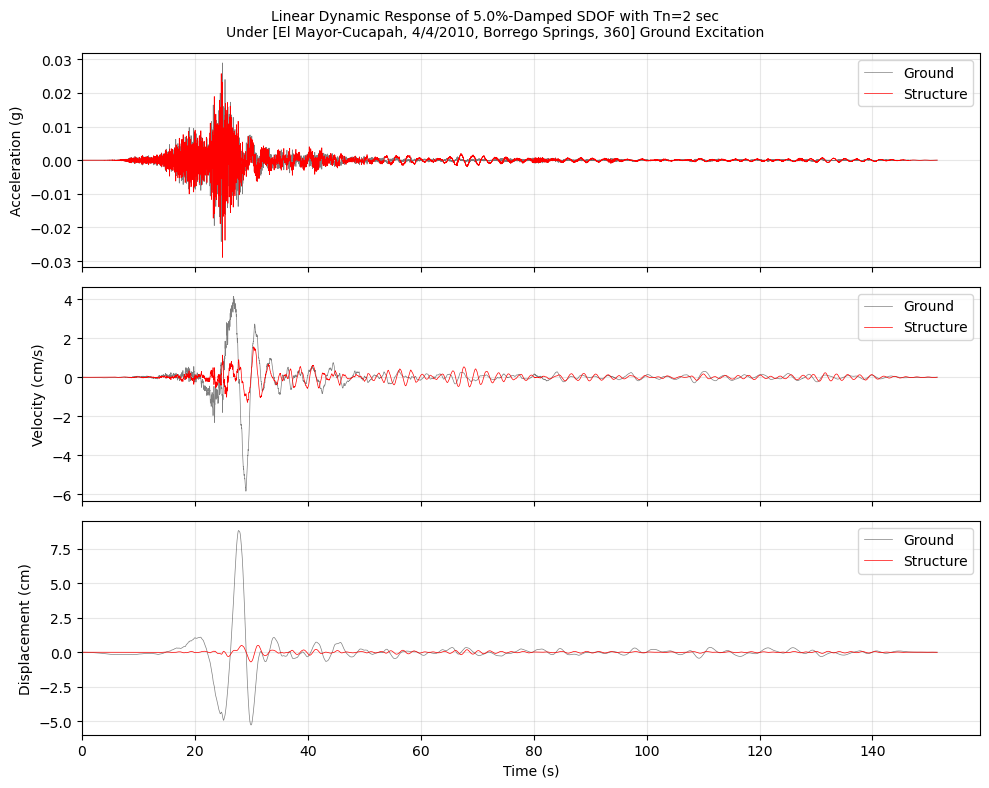

In [185]:
# Plot results
plt.style.use('default')  # Use default style instead of seaborn
fig, ax = plt.subplots(3, 1, sharex=True,figsize=(10, 8))

for i, key in enumerate(ground.keys()):
    ax[i].plot(t, ground[key], 'k-', label='Ground', alpha = 0.5, linewidth=0.5)
    if key == 'Acceleration':
        ax[i].plot(t, structure[key] / g, 'r-', label='Structure', linewidth=0.5)
    else:
        ax[i].plot(t, structure[key], 'r-', label='Structure', linewidth=0.5)
    ax[i].set_xlim(left=0)
    ax[i].set_ylabel(f'{key} ({header[key][-2].split()[-1].lower()})')
    ax[i].grid(True, alpha=0.3)
    ax[i].legend()

ax[-1].set_xlabel('Time (s)')
plt.suptitle(f"Linear Dynamic Response of {100*zeta}%-Damped SDOF with Tn={t_n} sec\nUnder [{title_lines[1]}] Ground Excitation", fontsize=10)
plt.tight_layout()
plt.show()

In [187]:
# System parameters
t_n_values = np.arange(0.05, 4.05, 0.05)  # natural periods from 0.1 to 10 sec
omega_n = 2 * np.pi / t_n_values # natural frequencies (rad/s)
zeta = 0.05  # damping ratio (5%)
g = 9.81 * 100  # gravitational acceleration (cm/s2)
# Time parameters
t = time['Acceleration']

# Create interpolation function for ground motion
acc_interp = interp1d(t, ground['Acceleration'] * g, bounds_error=False, fill_value=0.0)

# Pre-calculate ground acceleration for all time points
acc_t = acc_interp(t)

# Vectorized system equations
def sdof_system_vectorized(t_val, y, omega_n_array):
    # y shape is (2*n_periods, ) where first n_periods elements are displacements
    # and second n_periods elements are velocities
    n_periods = len(omega_n_array)
    
    # Reshape y into displacement and velocity arrays
    displacement = y[:n_periods]
    velocity = y[n_periods:]
    
    # Calculate derivatives
    d_displacement = velocity
    d_velocity = np.zeros_like(displacement)
    
    # Get current acceleration value using interpolation
    current_acc = acc_interp(t_val) if t_val < t[-1] else 0
    
    # Calculate d_velocity for each period
    for i in range(n_periods):
        d_velocity[i] = -omega_n_array[i]**2 * displacement[i] - \
                       2 * zeta * omega_n_array[i] * velocity[i] - \
                       current_acc
    
    return np.concatenate([d_displacement, d_velocity])

# Calculate natural frequencies
omega_n_array = 2 * np.pi / t_n_values

# Set up initial conditions for all periods at once
n_periods = len(t_n_values)
y0 = np.zeros(2 * n_periods)  # First n_periods zeros for displacement, second for velocity

# Solve the system for all periods at once
sol = solve_ivp(
    lambda t, y: sdof_system_vectorized(t, y, omega_n_array),
    t_span=[0, t[-1]],
    y0=y0,
    t_eval=t,
    method='RK45',
    rtol=1e-8,
    atol=1e-8
)

# Extract and organize results
n_time = len(t)
displacement = np.zeros((n_periods, n_time))
velocity = np.zeros((n_periods, n_time))
acceleration = np.zeros((n_periods, n_time))

for i in range(n_periods):
    displacement[i] = sol.y[i]
    velocity[i] = sol.y[i + n_periods]
    acceleration[i] = -omega_n_array[i]**2 * displacement[i] - \
                     2 * zeta * omega_n_array[i] * velocity[i] - \
                     ground['Acceleration'] * g

structure = {
    'Displacement': displacement,
    'Velocity': velocity,
    'Acceleration': acceleration
}


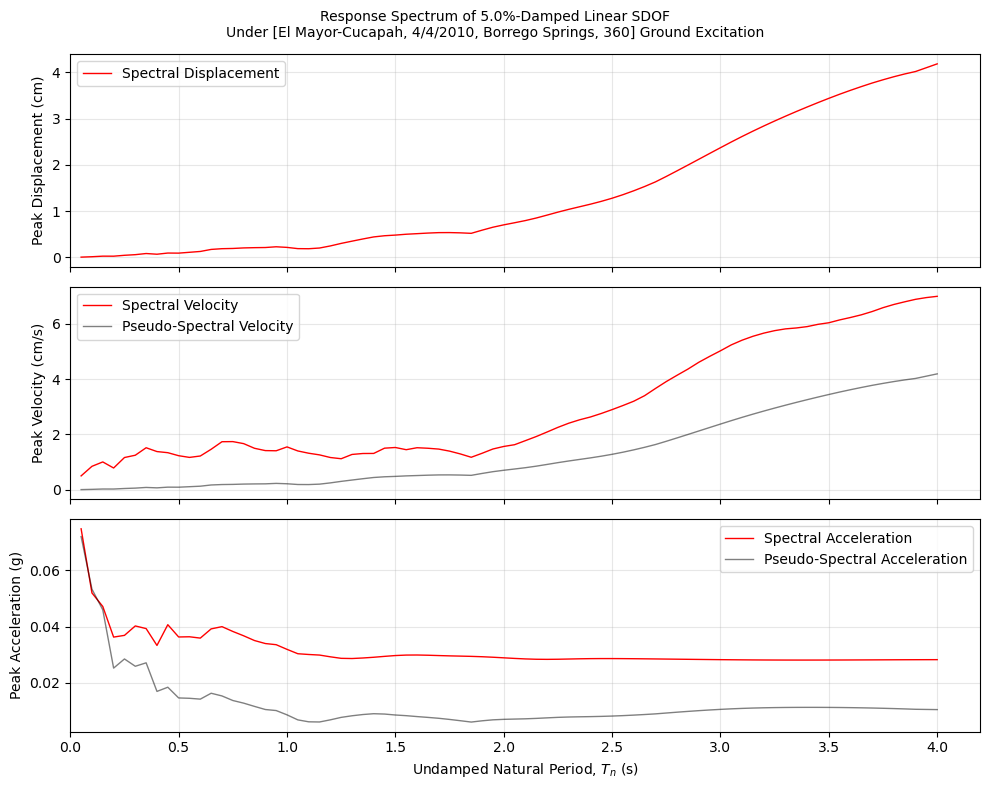

In [195]:

s_d = np.max(np.abs(structure['Displacement']), axis=1)

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 8))


for i, key in enumerate(structure.keys()):
    peak = np.max(np.abs(structure[key]), axis=1)

    if key == 'Acceleration':
        peak = peak / g
        s = s_d * np.power(omega_n, 2) / g
    elif key == 'Displacement':
        s = s_d * omega_n
    else:  # Displacement
        s = s_d
        
    ax[i].plot(t_n_values, peak, 'r-', linewidth=1, label=f'Spectral {key}')
    if key in ['Acceleration', 'Velocity']:
        ax[i].plot(t_n_values, s, 'k-', alpha=0.5, linewidth=1, label=f'Pseudo-Spectral {key}')
    ax[i].set_xlim(left=0)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_ylabel(f'Peak {key} ({header[key][-2].split()[-1].lower()})')
    ax[i].legend()


ax[-1].set_xlabel('Undamped Natural Period, $T_n$ (s)')
plt.suptitle(f"Response Spectrum of {100*zeta}%-Damped Linear SDOF\nUnder [{title_lines[1]}] Ground Excitation", fontsize=10)
plt.tight_layout()
plt.show()
